# CHANGE BDD STRUCTURE

In [2]:
import os 
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_to_bdd = "/home/basile/Documents/projet_bees_detection_basile/data_bees_detection/whole_dataset_cropped_with_cleaned_structure"
path_to_csv = "/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/final_datafiles/dataset_yolo_cropped_with_real_labels.csv"

In [5]:
# Create all the folders for the new structure

if not os.path.exists(path_to_bdd):
    os.mkdir(path_to_bdd)       

df = pd.read_csv(path_to_csv)
species = df["Real labels"].unique()

for specie in species:

    path = os.path.join(path_to_bdd, specie)

    if not os.path.exists(path):
        os.mkdir(path)

In [6]:
# Copy all the images in the right folder
# the name of the image is the concatenation of the path and the name of the image

for index, row in df.iterrows():

    
    image_path = row["Paths"]
    real_label = row["Real labels"]
    image_name = "_".join(row["Paths"].split("/")[6:])

    shutil.copy(os.path.join(image_path), os.path.join(path_to_bdd, real_label, image_name))



In [7]:
# Save the new dataset in a csv file

df = pd.DataFrame(columns=["Paths", "Labels"])


for specie in species:

    path = os.path.join(path_to_bdd, specie)

    temp = pd.DataFrame(columns=["Paths", "Labels"])
    temp["Paths"] = [os.path.join(path, image) for image in os.listdir(path)]
    temp["Labels"] = specie

    df = pd.concat([df, temp])

df.to_csv("/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/final_datafiles/dataset_yolo_cropped_with_cleaned_structure.csv", index=False)

# GEN TRAIN TEST VAL

To start with, we'll create a simple dataset
- only images labelled at species level
- only species with more than a specified nb of pictures
- no hierarchy between databases

1/ Filter dataset

In [15]:
def filter_dataset(only_species=True, min_images=None,hierarchy=False,df_dataset=None):
    """
    Filter the dataset according to specified criteria. 
    Parameters
    ---------------
    only_species : keep only the pictures labelled in picture level
    min_images : keep only the taxa that have more than x images
    path_to_dataset : dataset to filter in csv
            # Path #Labels

    Returns 
    --------------
    df_dataset : filtered dataset # Paths # Labels
    species : species in filtered dataset # Specie # Nb_img

    """


    # Take only the images labelled as species (i.e. real labels has more than 1 word)
    if only_species:
        df_dataset = df_dataset[df_dataset["Labels"].str.contains(" ")]
  
    # Get the number of species that have more than min_images images
    if min_images is not None : 

        species = df_dataset['Labels'].value_counts()[df_dataset['Labels'].value_counts() > min_images]

        # Convert the series to a dataframe
        species = species.to_frame()

        # Reset the index
        species.reset_index(inplace=True)

        # Rename the columns
        species.columns = ['Species', 'Number of images']

        # Filter the dataset
        df_dataset = df_dataset[df_dataset["Labels"].isin(species["Species"])]

    return df_dataset, species

df_dataset=pd.read_csv("/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/final_datafiles/dataset_yolo_cropped_with_cleaned_structure.csv")
df_dataset, species = filter_dataset(only_species=True, min_images=20000,
                                      df_dataset=df_dataset)

In [16]:
# take only 20 pictures per species
df_dataset = df_dataset.groupby('Labels').head(2000)

In [17]:
df_dataset['Labels'].value_counts()

Bombus terrestris    2000
Apis mellifera       2000
Name: Labels, dtype: int64

2/ Split the filtered dataset into train / test / val 

In [18]:
# For each specie 80% of the images are used for training 10% for validation and 10% for testing

def split_dataset(df_dataset=None, df_dataset__species= None, path_to_output= None):
    """
    Split the dataset into train, valid and test set, 
    with 80% of the images for training, 10% for validation and 10% for testing

    Parameters
    ----------
    df_dataset : pandas dataframe of all the pictures
                # Paths # Labels
    df_dataset_species : pandas dataframe with only the filtered species   
                # Species # Number of images
    path_to_output : path to the output folder where the csv files will be saved

    Returns
    -------
    df_train : pandas dataframe of the training set
                # Paths # Real labels
    df_valid : pandas dataframe of the validation set
                # Paths # Real labels
    df_test : pandas dataframe of the testing set   
                # Paths # Real labels

    Csv files :
     whole dataset 
     train/test/val
     correspondance label/id
    are saved in the output folder

    """


    # Create empty dataframes
    df_train = pd.DataFrame()
    df_valid = pd.DataFrame()
    df_test = pd.DataFrame()

    for specie in species['Species']:

        df_img = df_dataset[df_dataset['Labels'] == specie]

        # shuffle the dataframe
        df_img = df_img.sample(frac=1).reset_index(drop=True)

        # get the number of images
        nb_img = len(df_img)

        # get the number of images for each set
        nb_img_train = int(nb_img * 0.8)
        nb_img_valid = int(nb_img * 0.1)
        nb_img_test = int(nb_img * 0.1)

        # get the dataframe for each set
        df_img_train = df_img.iloc[:nb_img_train]
        df_img_valid = df_img.iloc[nb_img_train:nb_img_train+nb_img_valid]
        df_img_test = df_img.iloc[nb_img_train+nb_img_valid:]

        # Concatenate the dataframe for each set
        df_train = pd.concat([df_train, df_img_train])
        df_valid = pd.concat([df_valid, df_img_valid])
        df_test = pd.concat([df_test, df_img_test])

   
    # Drop the Real labels column
    df_train.drop(columns=['Labels'], inplace=True)
    df_valid.drop(columns=['Labels'], inplace=True)
    df_test.drop(columns=['Labels'], inplace=True)

    if not os.path.exists(path_to_output):
        os.mkdir(path_to_output)

    # save the dataframe to csv
    df_train.to_csv(os.path.join(path_to_output, 'train.csv'), index=False)
    df_valid.to_csv(os.path.join(path_to_output, 'valid.csv'), index=False)
    df_test.to_csv(os.path.join(path_to_output, 'test.csv'), index=False) 

    # save the whole dataset to csv
    df_dataset.to_csv(os.path.join(path_to_output, 'dataset.csv'), index=False)
    species.to_csv(os.path.join(path_to_output,'dataset_summary.csv'),index=False)


    return df_train, df_valid, df_test


df_train, df_valid, df_test = split_dataset(df_dataset,species,"/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/classification/inputs/VGG16_2_species")

3/ Create a folder to store this split

In [19]:
def copy_split_to_folder(path_to_folder=None, df_train=None ,df_test=None,df_valid=None,species=None):
    """
    Copy the pictures in a new folder
    """

    # Creates folders
    if not os.path.exists(path_to_folder):
        os.mkdir(path_to_folder)

    names = ['train','test','valid']
    dfs = [df_train,df_test,df_valid]

    def df_to_folder(df,name):
        
        if not os.path.exists(os.path.join(path_to_folder,name)):
            os.mkdir(os.path.join(path_to_folder,name))

        for specie in species['Species']: 

            if not os.path.exists(os.path.join(path_to_folder,name,specie)):
                os.mkdir(os.path.join(path_to_folder,name,specie))

      
        for old_path in df['Paths']:

            new_path = os.path.join(path_to_folder, name,('/').join(old_path.split(os.path.sep)[-2:]))
            old_path = os.path.join(old_path)
            shutil.copy(old_path,new_path)
    

    for name,df in zip(names,dfs):
        df_to_folder(df,name)


copy_split_to_folder(path_to_folder='/home/basile/Documents/projet_bees_detection_basile/data_bees_detection/VGG16_2_species',df_train=df_train,df_test=df_test,df_valid=df_valid,species=species)


4/ Convert it to dataset 

In [20]:
import keras
import tensorflow as tf
from keras.utils import image_dataset_from_directory


def load_data_from_dir(path_to_dir=None,IMG_SIZE=None,BATCH_SIZE=None):
    """
    Load the data from the folder
    """

    path_train = os.path.join(path_to_dir,'train')
    path_test = os.path.join(path_to_dir,'test')
    path_valid = os.path.join(path_to_dir,'valid')

    train_ds = keras.utils.image_dataset_from_directory(
        directory= path_train,
        labels='inferred',
        label_mode='categorical',
        shuffle = True,
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE))

    valid_ds = keras.utils.image_dataset_from_directory(
        directory= path_valid,
        labels='inferred',
        label_mode='categorical',
        shuffle = True,
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE))

    test_ds = keras.utils.image_dataset_from_directory(
        directory= path_test,
        labels='inferred',
        label_mode='categorical',
        shuffle = True,
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE))


    return train_ds, test_ds , valid_ds


train_ds, test_ds , valid_ds = load_data_from_dir(path_to_dir='/home/basile/Documents/projet_bees_detection_basile/data_bees_detection/VGG16_2_species',IMG_SIZE=128,BATCH_SIZE=12)



Found 3200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


# CREATE MODEL

1/ COMPILE SIMPLEST MODEL

In [21]:
from keras.applications.vgg16 import VGG16

IMG_SIZE = 128

model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),include_top=False)

# NB_CLASSES = species.shape[0]
NB_CLASSES = len(train_ds.class_names)


# create a classifier model on top
x = model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(NB_CLASSES, activation='softmax')(x)

# combine the two models
model = keras.Model(inputs=model.input, outputs=predictions)

# set parameters for training
EPOCHS = 80
# BATCH_SIZE = 8
LOSS = 'binary_crossentropy'
OPTI = 'adam'
METRICS = ['binary_accuracy']

model.compile(optimizer=OPTI, loss=LOSS, metrics=METRICS)



2/ Train the model

2.1 Train simplest

In [ ]:
# train the model
history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

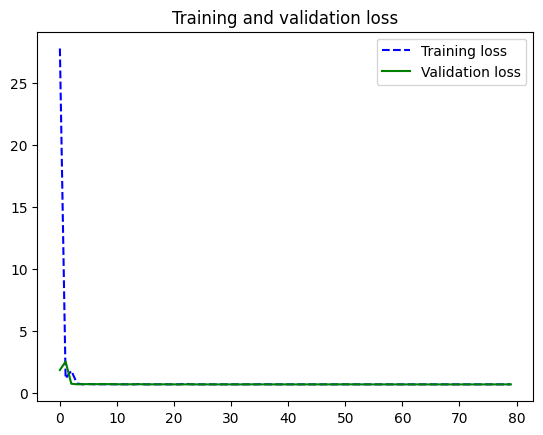

In [30]:
import matplotlib.pyplot as plt
def plot_training_analysis(history, metric='loss'):    

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.show()

plot_training_analysis(history, metric='loss')

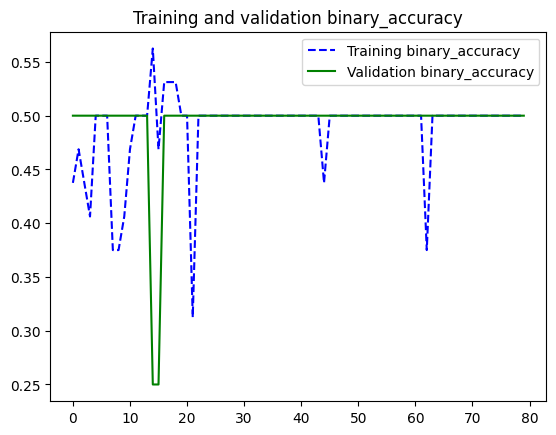

In [ ]:
plot_training_analysis(history, metric='binary_accuracy')

In [ ]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 34ms/step - loss: 0.6931 - binary_accuracy: 0.5000


[0.6931489706039429, 0.5]

In [ ]:
# callbacks
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/classification/benchmark/VGG16_20_pictures/VGG16_20_pictures.h5',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='min',
    save_best_only=True,
    #save_freq=16,
    verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.00001,
    patience=90,
    verbose=1,
    mode="auto")

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1,
                              patience=5, min_lr=0.00001, verbose=1)


In [ ]:
history = model.fit(train_ds,validation_data=valid_ds,epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[model_checkpoint_cb,early_stopping_cb,reduce_lr_cb])

In [ ]:
# evaluate model

# load best weights
model.load_weights('/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/classification/benchmark/VGG16_20_pictures/VGG16_20_pictures.h5')

# evaluate model
model.evaluate(test_ds,batch_size=BATCH_SIZE)



1/1 [==============================] - 0s 34ms/step - loss: 0.6945 - categorical_accuracy: 0.3333 - precision: 0.3333 - recall: 0.3333


[0.6944556832313538,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408]

# Evaluate with hierarchical loss

In [ ]:

from numpy.ma.core import transpose
from keras import backend as K
import math
import tensorflow as tf


def get_hierarchy(path_hierarchy,path_classes):
    """
    Get the hierarchy of the species
    """
    hierarchie = pd.read_csv(path_hierarchy)

    hierarchie = hierarchie.drop(columns=["tribe"])

    species = hierarchie["species"].unique()
    nb_species = len(species)

    genus = list(hierarchie["genus"].unique())
    nb_genus = len(genus)

    family = list(hierarchie["family"].unique())
    nb_family = len(family)

    subfamily = list(hierarchie["subfamily"].unique())
    nb_subfamily = len(subfamily)

    print("nb species : ", nb_species)
    print("nb genus : ", nb_genus)
    print("nb family : ", nb_family)
    print("nb subfamily : ", nb_subfamily)

    species_to_genus = np.zeros((nb_genus, nb_species))
    genus_to_subfamily = np.zeros((nb_subfamily, nb_genus))
    subfamily_to_family = np.zeros((nb_family, nb_subfamily))


    data = pd.read_csv(path_classes)
    data.columns = ["species", "0"]
   
    
    for i in range(nb_species):
        nb_images = data.at[i, "0"]
        # species -> genus
        genus_species = hierarchie.at[i, "genus"]
        ind_genus = genus.index(genus_species)
        species_to_genus[ind_genus, i] = 1

        # genus -> subfamily
        subfamily_species = hierarchie.at[i, "subfamily"]
        ind_subfamily = subfamily.index(subfamily_species)
        genus_to_subfamily[ind_subfamily, ind_genus] = 1

        # subfamily -> family
        family_species = hierarchie.at[i, "family"]
        ind_family = family.index(family_species)
        subfamily_to_family[ind_family, ind_subfamily] = 1


    return species_to_genus, genus_to_subfamily, subfamily_to_family,hierarchie


def Hierarchicaloss(species_to_genus, genus_to_subfamily, subfamily_to_family, batch_size, alpha=0.1):

    def weight(height=1):
      return math.exp(-alpha * height)
    
    def species_loss(y_true, y_pred):
      height = 0
      return weight(height) * K.categorical_crossentropy(y_true, y_pred)
  
    def species_to_genus_loss(y_true, y_pred):
      height = 1
      y_true_genus = K.transpose(tf.raw_ops.MatMul(a=species_to_genus, b=tf.cast(y_true, tf.float64), transpose_b=True))
      y_pred_genus = K.transpose(tf.raw_ops.MatMul(a=species_to_genus, b=tf.cast(y_pred, tf.float64), transpose_b=True))
      return weight(height) * K.categorical_crossentropy(y_true_genus, y_pred_genus), y_true_genus, y_pred_genus
    
    def genus_to_subfamily_loss(y_true, y_pred):
      height = 2
      y_true_subfamily = K.transpose(tf.raw_ops.MatMul(a=genus_to_subfamily, b=y_true, transpose_b=True))
      y_pred_subfamily = K.transpose(tf.raw_ops.MatMul(a=genus_to_subfamily, b=y_pred, transpose_b=True))
      return weight(height) * K.categorical_crossentropy(y_true_subfamily, y_pred_subfamily), y_true_subfamily, y_pred_subfamily
    
    def subfamily_to_family_loss(y_true, y_pred):
      height = 3
      y_true_family = K.transpose(tf.raw_ops.MatMul(a=subfamily_to_family, b=y_true, transpose_b=True))
      y_pred_family = K.transpose(tf.raw_ops.MatMul(a=subfamily_to_family, b=y_pred, transpose_b=True))
      return weight(height) * K.categorical_crossentropy(y_true_family, y_pred_family)

    def HIERARCHICAL_loss(y_true, y_pred):
      loss_species = tf.cast(species_loss(y_true, y_pred), tf.float64)
      loss_genus, y_true_genus, y_pred_genus = species_to_genus_loss(y_true, y_pred)
      loss_subfamily, y_true_subfamily, y_pred_subfamily = genus_to_subfamily_loss(y_true_genus, y_pred_genus)
      loss_family = subfamily_to_family_loss(y_true_subfamily, y_pred_subfamily)
      return (loss_species + loss_genus + loss_subfamily + loss_family)/batch_size
   
    # Return a function
    return HIERARCHICAL_loss

CLASS_NAMES = test_ds.class_names

def analyse_accuracy_hierarchie(y_pred, y_true, hierarchie):
  accuracy = 0
  accuracy_genus = 0
  accuracy_family = 0
  accuracy_subfamily = 0
  prediction = np.argmax(y_pred, axis=1)
  ground_truth = np.argmax(y_true, axis=1)
  
  for i in range(len(y_pred)):
    true_species = CLASS_NAMES[ground_truth[i]]
    pred_species = CLASS_NAMES[prediction[i]]

    if (true_species == pred_species):
      accuracy += 1.
      accuracy_genus += 1.
      accuracy_family += 1.
      accuracy_subfamily += 1.
    else:
      true_genus = hierarchie.at[true_species, "genus"]
      true_family = hierarchie.at[true_species, "family"]
      true_subfamily = hierarchie.at[true_species, "subfamily"]
      pred_genus = hierarchie.at[pred_species, "genus"]
      pred_family = hierarchie.at[pred_species, "family"]
      pred_subfamily = hierarchie.at[pred_species, "subfamily"]
      if (true_genus == pred_genus):
        accuracy_genus += 1.
      if (true_family == pred_family):
        accuracy_family += 1.
      if (true_subfamily == pred_subfamily):
        accuracy_subfamily += 1.
      
  accuracy = accuracy/len(y_pred)
  accuracy_genus = accuracy_genus/len(y_pred)
  accuracy_family = accuracy_family/len(y_pred)
  accuracy_subfamily = accuracy_subfamily/len(y_pred)

  print("Accuracy : " + str(accuracy))
  print("Accuracy genus : " + str(accuracy_genus))
  print("Accuracy family : " + str(accuracy_family))
  print("Accuracy subfamily : " + str(accuracy_subfamily))

In [ ]:

species_to_genus, genus_to_subfamily, subfamily_to_family,hierarchy = get_hierarchy("/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/classification/benchmark/VGG16_03_05/hierarchy.csv","/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/classification/benchmark/VGG16_03_05/dataset_summary.csv")

loss = Hierarchicaloss(species_to_genus, genus_to_subfamily, subfamily_to_family, batch_size=16, alpha=0.1)

model.compile(optimizer=OPTI, loss=loss, metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.load_weights('/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/classification/saved_weights/VGG16_1.h5')








nb species :  178
nb genus :  40
nb family :  6
nb subfamily :  15


In [ ]:
from keras.applications.vgg16 import VGG16

IMG_SIZE = 64

model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),include_top=False)

# NB_CLASSES = species.shape[0]
NB_CLASSES = len(train_ds.class_names)


# create a classifier model on top
x = model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(NB_CLASSES, activation='softmax')(x)

# combine the two models
model = keras.Model(inputs=model.input, outputs=predictions)

# set parameters for training
EPOCHS = 80
BATCH_SIZE = 8
OPTI = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
# OPTI = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
LOSS = tf.keras.losses.CategoricalCrossentropy()
LOSS = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]

# compile model
model.compile(optimizer=OPTI, loss=LOSS, metrics=METRICS)
